In [ ]:
import matplotlib
import networkx as nx
import numpy as np
import random as rd
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages

## Defining Global Variables and Functions

In [ ]:
N = 1000
p = 0.01
seed = 1
np.random.seed(seed)
rd.seed(seed)

### Random Graph Initialization
Here we use Erdős–Rényi model to create a random network (N=1000, p=0.01). Opinions are in $\{0, 1\}$ and they are assigned randomly with the same weight to the nodes as an attribute.

In [ ]:
def initialize(N, p):
  opinions = np.random.randint(0, 2, N)
  G = nx.erdos_renyi_graph(N, p, directed=False)
  opinion_dict = dict(zip(list(G.nodes()), opinions))
  nx.set_node_attributes(G, opinion_dict, 'opinion')
  return G

### Voter Model
This is the implementation of the voter model in opinion dynamic. `voter_model_update` updates a single node opinion by assiging it the opinion of a randomly chosen neighbor.

In [ ]:
def voter_model_update(G, node):
  neighbors = list(G.neighbors(node))
  if len(neighbors) == 0:
    return
  selected_neighbor = rd.choice(neighbors)
  G.nodes[node]['opinion'] = G.nodes[selected_neighbor]['opinion']

### Majority Model
The function `majority_model_update` is used for updating a node according to the majority model. Opinion of a node is updated by getting the opinion of the majority of its neighbors' opinion. If both opinions are divided equally between neighbors, the node takes a random opinion.

In [ ]:
def majority_model_update(G, node):
  neighbors = list(G.neighbors(node))
  sum_of_opinions = 0

  if len(neighbors) == 0:
    return

  for n in neighbors:
    sum_of_opinions += G.nodes[n]['opinion']

  new_opinion = sum_of_opinions / len(neighbors)
  if new_opinion > 0.5:
    G.nodes[node]['opinion'] = 1
  elif new_opinion < 0.5:
    G.nodes[node]['opinion'] = 0
  else:
    G.nodes[node]['opinion'] = np.random.randint(0, 2, 1)[0]

### Hybrid Updating
In this part, we manage to choose between the majority and the voter model for a single node. The probability of choosing the majority model is determined by probability of `q`.

`dynamic_operation` function runs a synchronous iteration on the nodes.

In [ ]:
def update(G, node, q):
  r = np.random.uniform(0, 1)

  if r < q:
    majority_model_update(G, node)
  else:
    voter_model_update(G, node)

In [ ]:
def dynamic_operation(G, q):
  random_permuted_nodes = np.random.permutation(G.nodes())
  for n in random_permuted_nodes:
    update(G, n, q)

### Checking Relative Stability
To check reaching an approximate steady state i.e. remaining nodes's opinion on the same value, we measure the distance between opinions arrays on the last 10 iterations.

In [ ]:
def stability_check(latest_opinions, threshold=1):
  a = np.sum(abs(np.diff(latest_opinions, axis=0)), axis=1)
  return not np.all(a < threshold)

## Consensus Rate Vs. `q`
For each q in $\{0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0\}$, we run the dynamic operation on an ensemble of 50 on Erdős–Rényi random networks with random initial opinion configuration. Every loop continues until a relative steady state is reached.


In [ ]:
qs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
result = {}

In [ ]:
for q in qs:
  result[q] = [[], [], []]

  for i in range(50):
    G = initialize(N, p)
    G_new = G.copy()

    # For choosing the largest component instead of the whole network,
    # uncomment these lines

    # G_copy = G.copy()
    # Gcc = sorted(nx.connected_components(G_copy), key=len, reverse=True)
    # G_copy = G_copy.subgraph(Gcc[0])
    # G_new = G_copy.copy()

    components = nx.number_connected_components(G_new)

    steps = 0

    default_opinions = list(dict(nx.get_node_attributes(G, 'opinion')).values())
    latest_opinions = [default_opinions]

    condition = True
    while condition:
      steps += 1
      dynamic_operation(G_new, q)

      opinions = list(dict(nx.get_node_attributes(G_new, 'opinion')).values())
      latest_opinions += [opinions]
      latest_opinions = latest_opinions[-10:]
      condition = stability_check(latest_opinions)

    result[q][0].append(steps)
    result[q][1].append(np.sum(opinions) / len(G_new))
    result[q][2].append(components)
  print(q)

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


### Figures
Here we plot the fraction of runs leading to consensus vs. `q` (probablity of choosing the majority model over the voter model). Near all of samples reached to consensus as it was predicted because high connection probability for the `ER` model. The few sample which have not reached to full consensus are not fully connected networks.


In [ ]:
x = list(result.keys())
y = [(50 - len(set(v[1]) - set([0, 1]))) / 50 for i, v in result.items()]

In [ ]:
y

[0.98, 1.0, 0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.98, 1.0, 0.98]

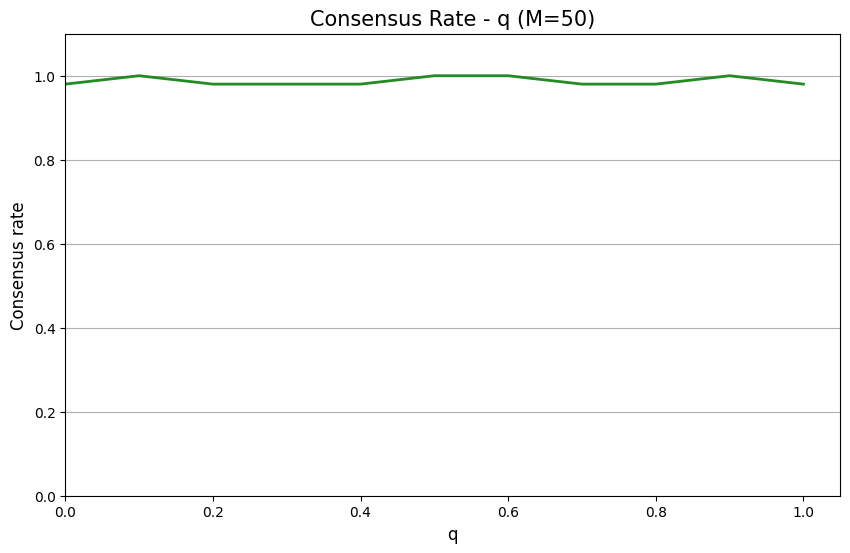

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, y, linewidth=2, color='forestgreen')
plt.grid(axis='y')

plt.ylim(bottom=0, top=1.1)
plt.xlim(left=0);
plt.title('Consensus Rate - q (M=50)', fontsize=15);
plt.xlabel('q', fontsize=12);
plt.ylabel('Consensus rate', fontsize=12);
plt.savefig("consensus_rate_q50.pdf", format="pdf", bbox_inches="tight")
plt.show()

In the second plot, we see the average number of steps it takes to reach the steady state for those samples which have achieved a consensus. For low `q`, higher propability of choosing the voter model dynamics, it takes relatively longer to reach the consensus, which is because of the its random nature.

In [ ]:
val = np.array(list(result.values()))
y = [np.average(list(val[i,0][((val[i,1]==1) | (val[i,1]==0))])) for i in range(11)]

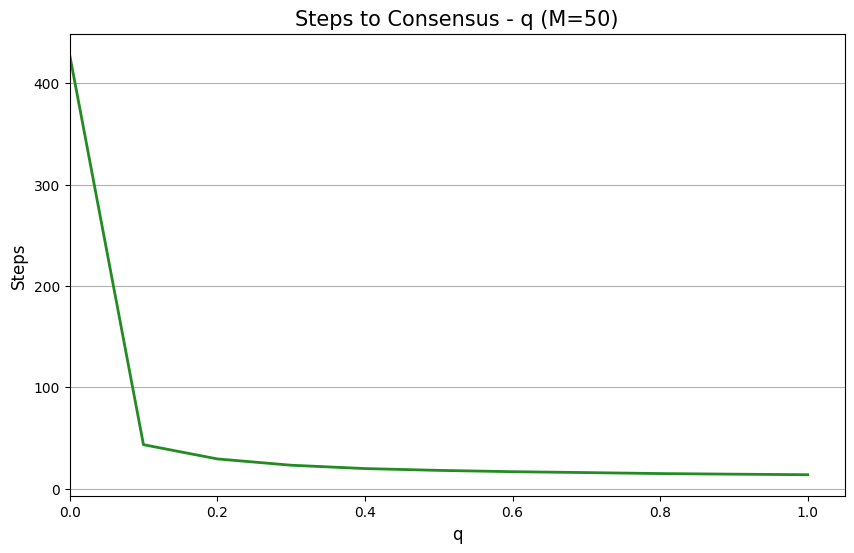

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, y, linewidth=2, color='forestgreen')
plt.grid(axis='y')

plt.xlim(left=0);
plt.title('Steps to Consensus - q (M=50)',fontsize=15);
plt.xlabel('q', fontsize=12);
plt.ylabel('Steps', fontsize=12);
plt.savefig("consensus_steps_q50.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Example Execution of the Dynamics

In [ ]:
def observe(G, file_name):
  color_map = []
  for node in G.nodes(data=True):
      if node[1]['opinion'] == 1:
          color_map.append('deeppink')
      else:
          color_map.append('deepskyblue')

  plt.figure(figsize=(12, 12))
  nx.draw(
      G,
      node_color=color_map,
      with_labels=False,
      node_size=140,
      edge_color='gray',
      width=0.5,
      alpha=0.9,
      pos=nx.spring_layout(G, seed=42)
  )
  plt.title('Network Visualization with Node Opinions')
  plt.savefig(f"{file_name}.pdf", format="pdf", bbox_inches="tight")
  plt.show()


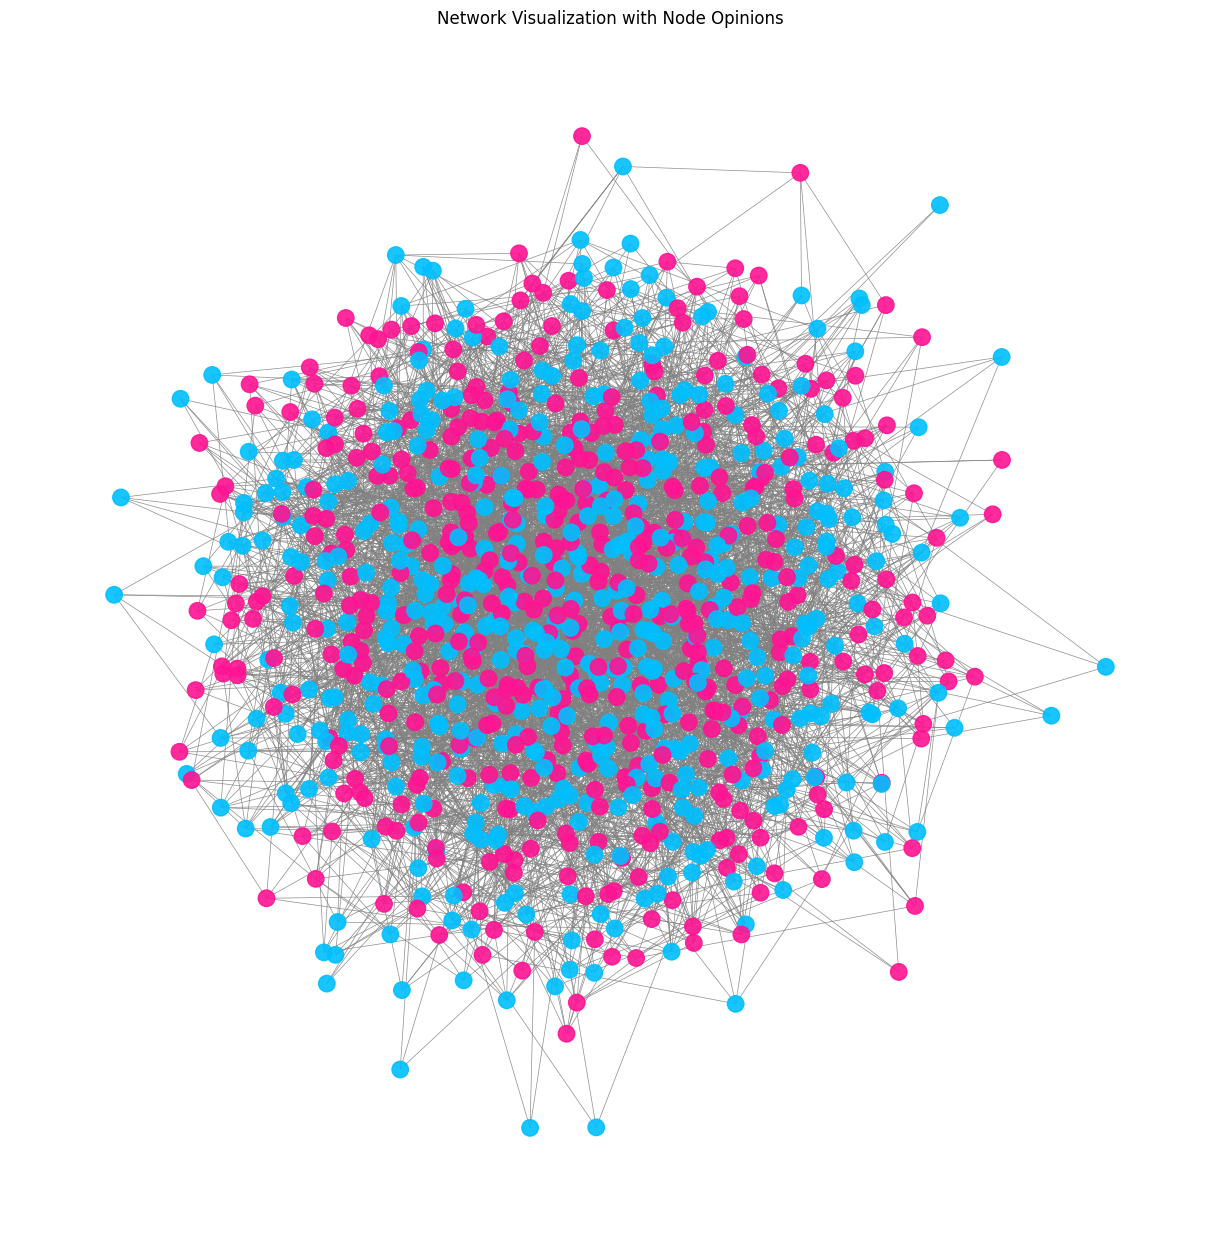

In [ ]:
observe(G, 'example_graph')